In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, LogFormatterMathtext
import xarray as xr
import numpy as np
import pandas as pd
import joblib
from xgboost import XGBRegressor

/data/keeling/a/xx24/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
# To load the colormap from the JSON file and recreate it
import json
from matplotlib.colors import ListedColormap
with open('/data/keeling/a/xx24/colormap.json', 'r') as json_file:
    loaded_colors = json.load(json_file)
    loaded_colors = [(r / 255, g / 255, b / 255) for r, g, b in loaded_colors]
    new_cmap = ListedColormap(loaded_colors)

In [3]:
def plot_map_log_robinson(var, cbar_label, cmap, title, vmin=None, vmax=None):
    """
    Robinson 投影下的对数比例全球图。
    1) 把 ≤0 值转为 NaN；
    2) 用剩余正值直接计算 vmin/vmax；
    3) 确保 vmin>0。
    """
    # 1) 屏蔽掉 ≤0
    data_pos = var.where(var > 0)

    # 2) 计算 vmin/vmax
    if vmin is None or vmax is None:
        vmin = float(data_pos.quantile(0.10))
        vmax = float(data_pos.quantile(0.90))
    # 确保 vmin>0
    eps = vmax * 1e-6
    vmin = max(vmin, eps)

    # 3) 创建 Robinson 投影的 Axes
    fig, ax = plt.subplots(
        figsize=(12, 8),
        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)}
    )

    # 4) 绘制 pcolormesh
    im = ax.pcolormesh(
        var['lon'], var['lat'], data_pos,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        shading='auto'
    )
    ax.set_global()
    ax.set_title(title)

    # 5) 地理要素
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.OCEAN, facecolor='white')

    # 6) 对数刻度 colorbar
    cbar = fig.colorbar(
        im, ax=ax,
        orientation='vertical',
        fraction=0.046, pad=0.04, shrink=0.65,
        label=cbar_label,
        format=LogFormatterMathtext(base=10)
    )

    # 确保主刻度落在 10^n
    cbar.locator = LogLocator(base=10)
    cbar.update_ticks()

    # 7) 网格线
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False

    plt.tight_layout()
    plt.show()

In [4]:
file = xr.open_dataset('/data/keeling/a/xx24/e/proj_ml/cesm_data/d651001/ensemble_combined/b.e21.ens_a.cam.h0.all_vars.201001-201112.nc',engine='netcdf4')
file

<xarray.Dataset>
Dimensions:          (lat: 192, lon: 288, lev: 32, ilev: 33, time: 24)
Coordinates:
  * lat              (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon              (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev              (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev             (ilev) float64 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * time             (time) object 2010-02-01 00:00:00 ... 2012-01-01 00:00:00
Data variables:
    so4              (time, lev, lat, lon) float32 ...
    ncl              (time, lev, lat, lon) float32 ...
    pom              (time, lev, lat, lon) float32 ...
    bc               (time, lev, lat, lon) float32 ...
    dst              (time, lev, lat, lon) float32 ...
    soa              (time, lev, lat, lon) float32 ...
    tot_number_conc  (time, lev, lat, lon) float32 ...
    bulk_diameter    (time, lev, lat, lon) float32 ...
    T                (time, lev, lat, lon) float32 ...
    RELHUM           (time, lev, lat, lon) float32 ...
    RHO_CLUBB        (time, lev, lat, lon) float32 ...
    CCN3             (time, lev, lat, lon) float32 ...

In [ ]:
time = 17
level = -1

# 1. 从 file 中读取所有场，取某一 time, 某一 lev，得到 DataArray
so4_da  = file['so4'].isel(time=time, lev=level) * 1e9
ncl_da  = file['ncl'].isel(time=time, lev=level) * 1e9
pom_da  = file['pom'].isel(time=time, lev=level) * 1e9
bc_da   = file['bc'].isel(time=time, lev=level)  * 1e9
dst_da  = file['dst'].isel(time=time, lev=level) * 1e9
soa_da  = file['soa'].isel(time=time, lev=level) * 1e9

tnc_da  = file['tot_number_conc'].isel(time=time, lev=level) * 1e-6
bdp_da  = file['bulk_diameter'].isel(time=time, lev=level) * 1e6
T_da    = file['T'].isel(time=time, lev=level)
RH_da   = file['RELHUM'].isel(time=time, lev=level) / 100 
rho_da  = file['RHO_CLUBB'].isel(time=time, lev=level)

ccn_01  = file['CCN3'].isel(time=time, lev=level)  # already in #/cm3

lat_vals = file['lat'].values    # (192,)
lon_vals = file['lon'].values    # (288,)


df = pd.DataFrame({
    'Temperature':          T_da.values.flatten(),
    'RH':                   RH_da.values.flatten(),
    'Density':              rho_da.values.flatten(),
    'Bulk_DP':              bdp_da.values.flatten(),
    'Num_Conc':             tnc_da.values.flatten(),
    'SO4':                  so4_da.values.flatten(),
    'NaCl':                 ncl_da.values.flatten(),
    'OIN':                  dst_da.values.flatten(),  
    'OC':                   pom_da.values.flatten(),  
    'BC':                   bc_da.values.flatten(),
    'SOA':                  soa_da.values.flatten(),
})

In [35]:
df

,Temperature,RH,Density,Bulk_DP,Num_Conc,SO4,NaCl,OIN,OC,BC,SOA
0,217.536102,1.080366,1.069888,0.361778,5.324997,0.000792,0.286958,0.000112,0.000699,0.000217,0.000398
1,217.536102,1.080366,1.069888,0.361778,5.324997,0.000792,0.286958,0.000112,0.000699,0.000217,0.000398
2,217.536102,1.080366,1.069888,0.361778,5.324997,0.000792,0.286958,0.000112,0.000699,0.000217,0.000398
3,217.536102,1.080366,1.069888,0.361778,5.324997,0.000792,0.286958,0.000112,0.000699,0.000217,0.000398
4,217.536102,1.080366,1.069888,0.361778,5.324997,0.000792,0.286958,0.000112,0.000699,0.000217,0.000398
...,...,...,...,...,...,...,...,...,...,...,...
55291,271.699371,0.978830,1.294141,0.166338,84.677315,0.021647,0.198868,0.022543,0.086600,0.005222,0.004843
55292,271.699402,0.978827,1.294141,0.166336,84.677429,0.021647,0.198856,0.022539,0.086601,0.005222,0.004843
55293,271.699432,0.978825,1.294141,0.166339,84.678177,0.021648,0.198868,0.022547,0.086602,0.005223,0.004844
55294,271.699432,0.978822,1.294140,0.166337,84.678368,0.021648,0.198854,0.022546,0.086602,0.005223,0.004844


In [6]:
def ml_predict(model, ss):
    if model == 'automl':
        model = joblib.load(f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/AutoML_emulator_CCN_VS_{ss}.pkl')
    elif model == 'lr':
        model = joblib.load(f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/LinearRegression_emulator_CCN_VS_{ss}.pkl')
    elif model == 'xgb':
        model = XGBRegressor(tree_method='hist', multi_strategy='multi_output_tree')
        model.load_model(f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/xgb_multi.model')
    else:
        raise ValueError(f"未知模型类型：{model!r}")    
    
    # 2. 预测（返回可能是 (n_samples,) 或 (n_samples, n_outputs)）
    y_all = model.predict(df)  

    # 3. 如果是多输出，就根据 ss 取对应那一列
    SS_IDX = {'0.1': 0, '0.3': 1, '0.6': 2, '1.0': 3,}
    if y_all.ndim == 2:
        idx = SS_IDX.get(ss)
        if idx is None:
            raise ValueError(f"不支持的 ss={ss!r}")
        y = y_all[:, idx]
    else:
        y = y_all

    y_grid = y.reshape(len(lat_vals), len(lon_vals))

    # 4. 重塑并转 DataArray
    da = xr.DataArray(
        y_grid,
        dims=('lat', 'lon'),
        coords={'lat': lat_vals, 'lon': lon_vals},
        name=f'ccn_{model}_{ss}'
    )
    return da

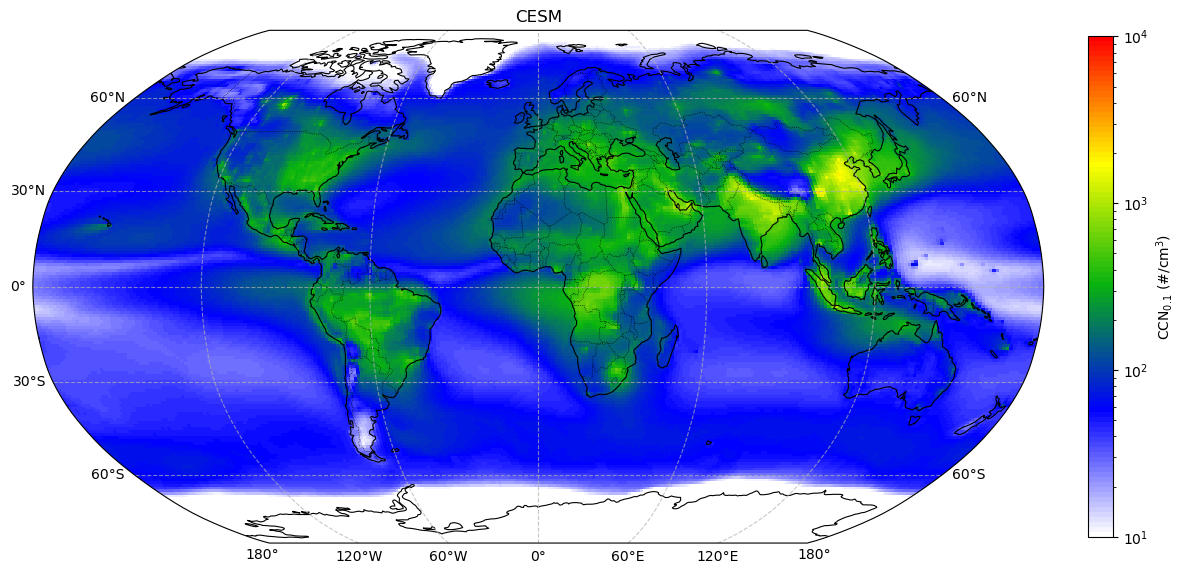

In [8]:
plot_map_log_robinson(ccn_01, r'$\rm CCN_{0.1}\ (\#/cm^3)$', new_cmap, 'CESM', vmin=1e1, vmax=1e4)

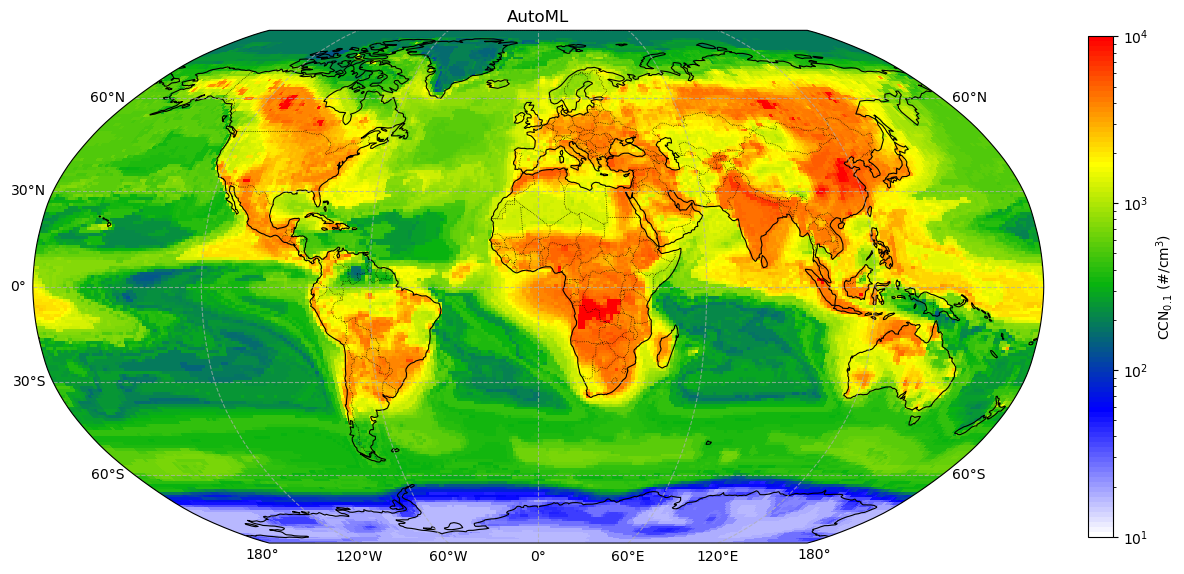

In [9]:
plot_map_log_robinson(ml_predict('automl', '0.1'), r'$\rm CCN_{0.1}\ (\#/cm^3)$', new_cmap, 'AutoML', vmin=1e1, vmax=1e4)

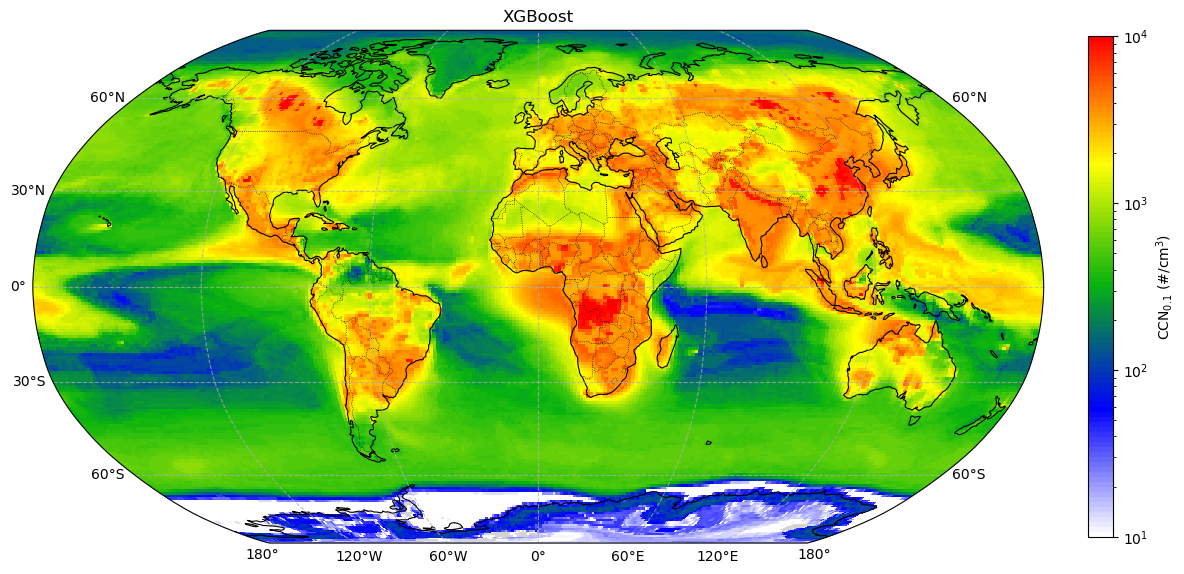

In [10]:
plot_map_log_robinson(ml_predict('xgb', '0.1'), r'$\rm CCN_{0.1}\ (\#/cm^3)$', new_cmap, 'XGBoost', vmin=1e1, vmax=1e4)

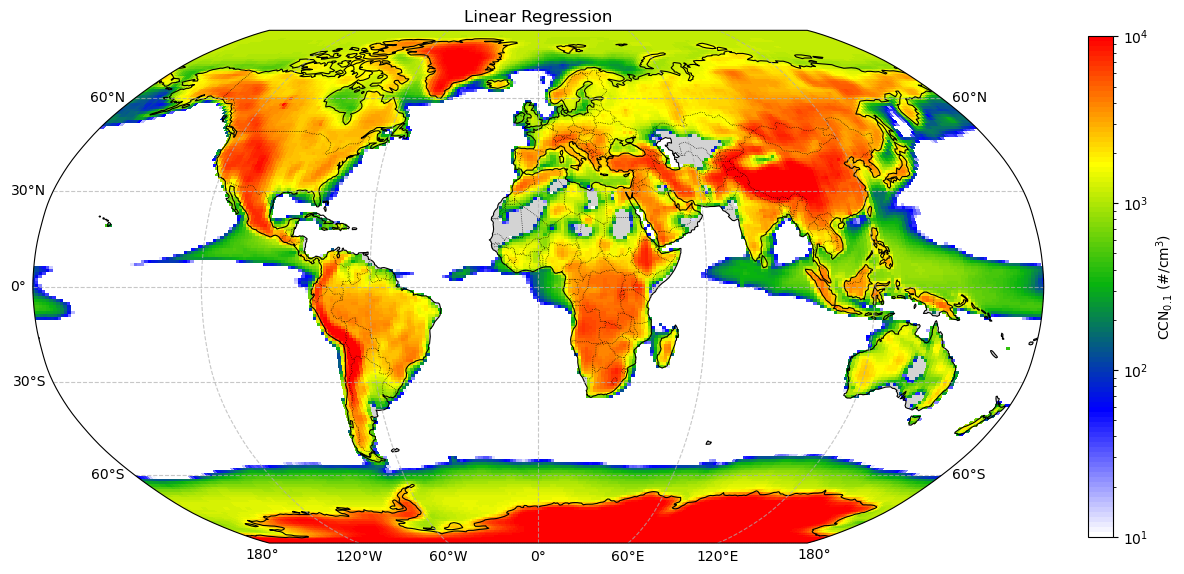

In [11]:
plot_map_log_robinson(ml_predict('lr', '0.1'), r'$\rm CCN_{0.1}\ (\#/cm^3)$', new_cmap, 'Linear Regression', vmin=1e1, vmax=1e4)

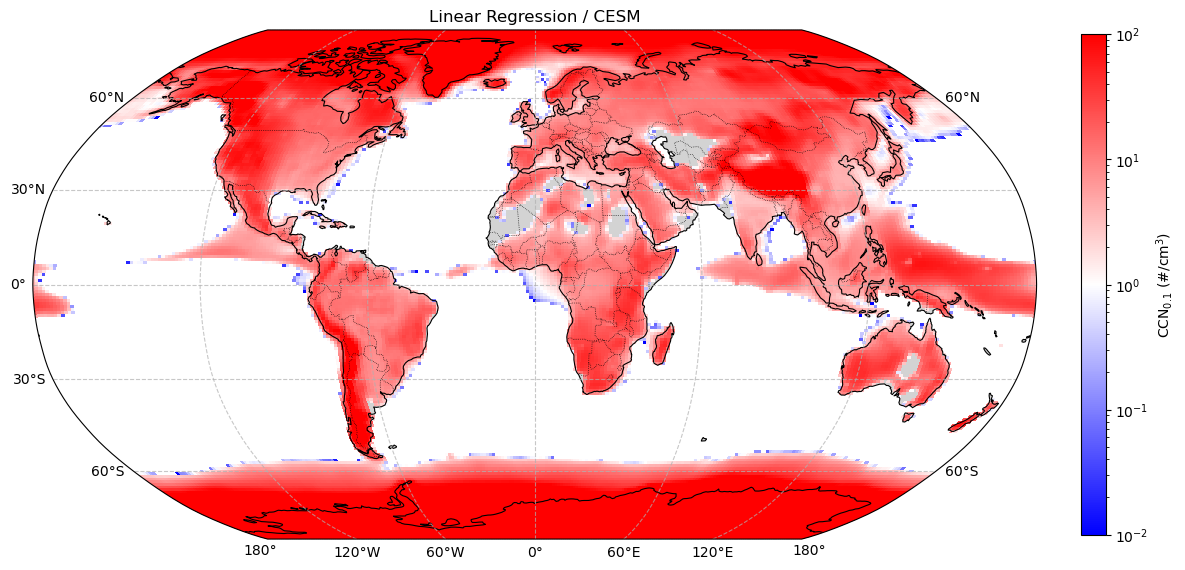

In [15]:
plot_map_log_robinson(ml_predict('lr', '0.1')/ccn_01, r'$\rm CCN_{0.1}\ (\#/cm^3)$', 'bwr', 'Linear Regression / CESM', vmin=1e-2, vmax=1e2)

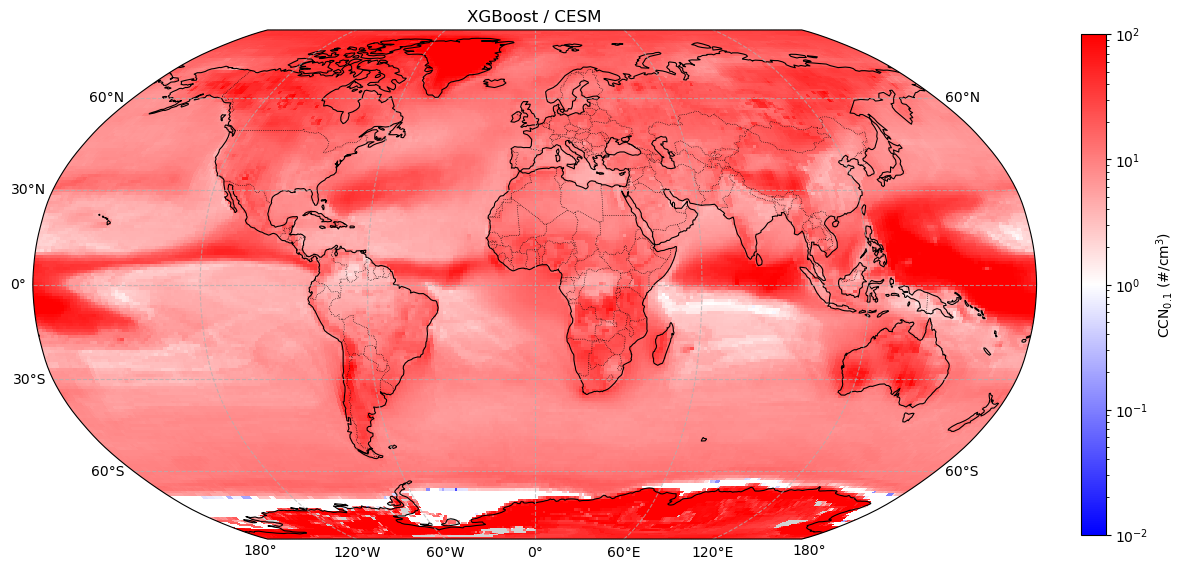

In [16]:
plot_map_log_robinson(ml_predict('xgb', '0.1')/ccn_01, r'$\rm CCN_{0.1}\ (\#/cm^3)$', 'bwr', 'XGBoost / CESM', vmin=1e-2, vmax=1e2)

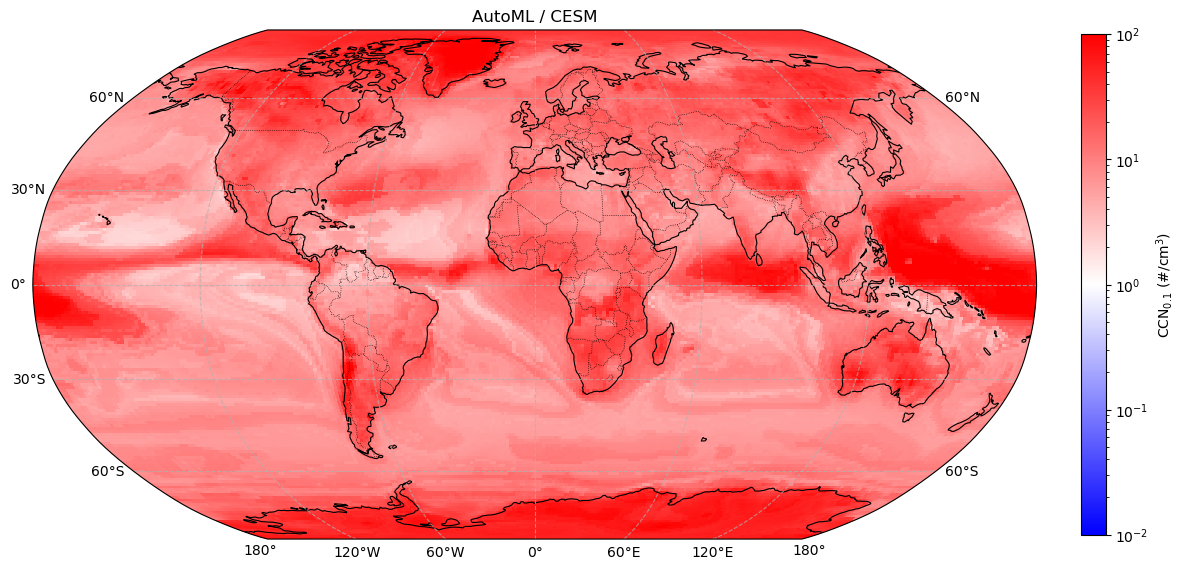

In [17]:
plot_map_log_robinson(ml_predict('automl', '0.1')/ccn_01, r'$\rm CCN_{0.1}\ (\#/cm^3)$', 'bwr', 'AutoML / CESM', vmin=1e-2, vmax=1e2)